# RVE Test 

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import compmod2 as cp2
import argiope as ag
import pandas as pd
import numpy as np
from string import Template
import inspect, os, local_settings, scipy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as mpl3d
import matplotlib.colors as colors
import matplotlib as mpl
%matplotlib nbagg

In [23]:
# USEFUL FUNCTIONS
def create_dir(path):
    try:
        os.mkdir(path)
    except:
        pass
# SETTINGS
workdir   = "_workdir/"
outputdir = "outputs/"
label   = "RVE"
create_dir(workdir)
create_dir(workdir + outputdir)

## Model settings

In [30]:
%%time
shape = np.array([4, 4, 4])
Ne = shape.prod()

def element_map(mesh):
    mesh.elements.loc[:, ("type", "solver", "") ] = "C3D8R"
    return mesh
    
    
def material_map(mesh):
    mesh.elements.materials = ["mat{0}".format(i) for i in mesh.elements.index]
    return mesh

dist = cp2.distributions.Weibull(k = 1., l = 1.e-2)
xt, x = dist.discretize(Ne, xmax = 1.)
np.random.shuffle(x)
E = 210.e3
nu = .3
materials = [ag.materials.ElasticPerfectlyPlastic(
                                 label = "mat{0}".format(i+1), 
                                 young_modulus = E, 
                                 poisson_ratio = nu, 
                                 yield_stress = x[i] * E) 
                                 for i in range(Ne)]

steps = [cp2.models.RVEStep(name = "loading1", 
                            cx = ("disp", .1),
                            field_output_frequency = 100),
         cp2.models.RVEStep(name = "unloading1", 
                            cx = ("force", 0.),
                            field_output_frequency = 100),
         cp2.models.RVEStep(name = "loading2", 
                            cx = ("disp", .1),
                            field_output_frequency = 100),]

sample = cp2.models.RVESample(shape = shape,
                              element_map = element_map,
                              material_map = material_map)
model = cp2.models.RVETest(label = label,
                           parts = {"sample":sample},
                           steps = steps,
                           materials = materials,
                           solver = "abaqus", 
                           solver_path = local_settings.ABAQUS_PATH,
                           workdir = workdir,
                           verbose = True)

CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 10.5 ms


## Solving

In [31]:
if True:
    model.write_input()
    #model.run_simulation()
    model.postproc()
    model.save(workdir + label + ".pckl")

#### POST-PROCESSING "RVE" USING POST-PROCESSOR "ABAQUS"
     Abaqus License Manager checked out the following license(s):
     "cae" release 6.13 from flex2-symme.univ-savoie.fr
     <7 out of 9 licenses remain available>.
  => POST-PROCESSED RVE: DURATION = 1.68s >


## Post-Processing 

In [32]:
model = ag.utils.load(workdir + label + ".pckl")
data = model.data["history"]
data.head()

areas                     dimensions                       disp  \
             A1        A2        A3         L1        L2        L3     U1   
frame                                                                       
0      1.000000  1.000000  1.000000      1.000  1.000000  1.000000  0.000   
1      0.999375  1.000687  1.000687      1.001  0.999688  0.999687  0.001   
2      0.998707  1.001349  1.001354      1.002  0.999356  0.999351  0.002   
3      0.998000  1.001992  1.002001      1.003  0.999004  0.998995  0.003   
4      0.997261  1.002617  1.002631      1.004  0.998636  0.998623  0.004   

                           energies    ...      strains                      \
             U2        U3        We    ...          E22       E33      LE11   
frame                                  ...                                    
0      0.000000  0.000000  0.000000    ...     0.000000  0.000000  0.000000   
1     -0.000312 -0.000313  0.095873    ...    -0.000312 -0.000313  0.001000   
2     -0.000644 -0.000649  0.353291    ...    -0.000644 -0.000649  0.001998   
3     -0.000996 -0.001005  0.732349    ...    -0.000996 -0.001005  0.002996   
4     -0.001364 -0.001377  1.199574    ...    -0.001364 -0.001377  0.003992   

                          stress          time    volume  
           LE22      LE33    S11 S22 S33     t         V  
frame                                                     
0      0.000000  0.000000    NaN NaN NaN  0.00  1.000000  
1     -0.000312 -0.000313    NaN NaN NaN  0.01  1.000374  
2     -0.000645 -0.000650    NaN NaN NaN  0.02  1.000704  
3     -0.000996 -0.001005    NaN NaN NaN  0.03  1.000994  
4     -0.001365 -0.001378    NaN NaN NaN  0.04  1.001250  

[5 rows x 33 columns]

<IPython.core.display.Javascript object>


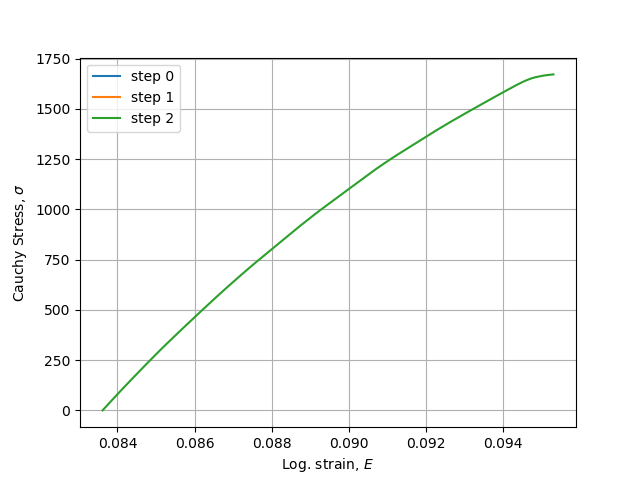

In [34]:
plt.figure()
for i in data.step.s.unique():
    step = data[data.step.s == i]
    plt.plot(step.strains.LE11, step.stress.S11, label = "step {0}".format(i))
plt.xlabel("Log. strain, $E$")
plt.ylabel("Cauchy Stress, $\sigma$")
plt.grid()
plt.legend(loc = "best")
plt.show()

In [ ]:
plt.figure()
for i in data.step.s.unique():
    step = data[data.step.s == i]
    plt.plot(step.strains.LE11, step.energies.Wp, label = "step {0}".format(i))
plt.xlabel("Log. strain, $E$")
plt.ylabel("Plastic Dissipated Energy, $W_p$")
plt.grid()
plt.legend(loc = "best")
plt.show()

## RVE plot

In [16]:
step_label = "loading1"
frame = -1
field_label = "LE"
component_label = "v11"

# FIELDS MANAGEMENT
fdata = model.parts["sample"].mesh.fields_metadata()
fields = model.parts["sample"].mesh.fields
F_id = fdata[(fdata.step_label == step_label) & (fdata.label == field_label)].sort_values("frame").index[frame]
F = fields[F_id].data[component_label]
fdata

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,EE,ISAMPLE,element,loading1,0
1,0,0,LE,ISAMPLE,element,loading1,0
2,0,0,PE,ISAMPLE,element,loading1,0
3,0,0,S,ISAMPLE,element,loading1,0
4,0,0,U,ISAMPLE,node,loading1,0
5,1,1,EE,ISAMPLE,element,loading1,0
6,1,1,LE,ISAMPLE,element,loading1,0
7,1,1,PE,ISAMPLE,element,loading1,0
8,1,1,S,ISAMPLE,element,loading1,0
9,1,1,U,ISAMPLE,node,loading1,0


<IPython.core.display.Javascript object>


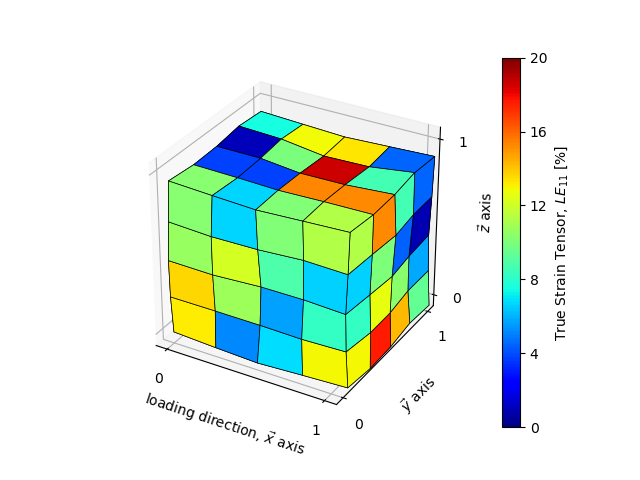

In [17]:
# PATCHES
vertices, emap = model.get_Poly3DCollection(deformed = True, 
                                            step_label = step_label, 
                                            frame = frame, 
                                            displacement_factor = 1.)
        
collection = mpl3d.art3d.Poly3DCollection(vertices)
collection.set_array(F.loc[emap] * 100)
collection.set_linewidth(.5)
collection.set_edgecolor("black")
collection.set_cmap(mpl.cm.jet)
collection.set_clim(0., 20.)

# FIGURE
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d', aspect = "equal")
ax1.add_collection3d(collection)
#ax1.axis("off")
ax1.set_xlabel(r'loading direction, $\vec x$ axis')
ax1.set_ylabel(r'$\vec y$ axis')
ax1.set_zlabel(r'$\vec z$ axis')
offset = .05
ax1.set_xlim3d(-offset, 1. + offset)
ax1.set_ylim3d(-offset, 1. + offset)
ax1.set_zlim3d(-offset, 1. + offset)
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_zticks([0, 1])
cbar = plt.colorbar(collection)
cbar.set_label(r"True Strain Tensor, $LE_{11}$ [$\%$]")
cbar.set_ticks(np.linspace(0., 20, 6))
plt.savefig("model.pdf")
plt.show()

## Periodic BC checking

In [20]:
U_id = fdata[(fdata.step_label == step_label) & (fdata.label == "U")].sort_values("frame").index[frame]
U = fields[U_id].data
nodes = model.parts["sample"].mesh.nodes

def check_direction(direction = "x"):
    """
    Calculates the difference of the displacements on 2 opposite faces that are normal to a given direction.
    """
    F0 = nodes[(nodes.sets.control == False) & (nodes.coords[direction] == 0.)].coords.sort_values(["x", "y", "z"])
    F1 = nodes[(nodes.sets.control == False) & (nodes.coords[direction] == 1.)].coords.sort_values(["x", "y", "z"])
    U0 = U.loc[F0.index].reset_index()
    U1 = U.loc[F1.index].reset_index()
    return U1 - U0

check_direction("x").describe()


,node,v1,v2,v3
count,25.0,2.500000e+01,25.0,25.0
mean,4.0,1.000000e-01,0.0,0.0
std,0.0,2.665862e-09,0.0,0.0
min,4.0,1.000000e-01,0.0,0.0
25%,4.0,1.000000e-01,0.0,0.0
50%,4.0,1.000000e-01,0.0,0.0
75%,4.0,1.000000e-01,0.0,0.0
max,4.0,1.000000e-01,0.0,0.0


In [21]:
check_direction("y").describe()

,node,v1,v2,v3
count,25.0,25.0,2.500000e+01,25.0
mean,20.0,0.0,-4.163784e-02,0.0
std,0.0,0.0,7.457459e-10,0.0
min,20.0,0.0,-4.163784e-02,0.0
25%,20.0,0.0,-4.163784e-02,0.0
50%,20.0,0.0,-4.163784e-02,0.0
75%,20.0,0.0,-4.163784e-02,0.0
max,20.0,0.0,-4.163784e-02,0.0


In [22]:
check_direction("z").describe()

,node,v1,v2,v3
count,25.0,25.0,25.0,2.500000e+01
mean,100.0,0.0,0.0,-4.791145e-02
std,0.0,0.0,0.0,1.103872e-09
min,100.0,0.0,0.0,-4.791145e-02
25%,100.0,0.0,0.0,-4.791145e-02
50%,100.0,0.0,0.0,-4.791145e-02
75%,100.0,0.0,0.0,-4.791145e-02
max,100.0,0.0,0.0,-4.791145e-02


The boundary conditions are perfectly matched. 